
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ゼロからの線形回帰実装

:label: `sec_linear_scratch`

これで、完全に機能する線形回帰の実装に取り​​組む準備が整いました。**このセクションでは、((i) モデル、(ii) 損失関数、(iii) ミニバッチ確率的勾配降下オプティマイザー、(iv) これらすべてをつなぎ合わせるトレーニング関数を含む、メソッド全体を最初から実装します。最後に**、:numref: `sec_synthetic-regression-data`から合成データ ジェネレーターを実行し、結果のデータセットにモデルを適用します。最新の深層学習フレームワークはこの作業のほぼすべてを自動化できますが、自分が何をしているのかを本当に理解していることを確認するには、物事を最初から実装することが唯一の方法です。さらに、モデルをカスタマイズするときは、独自のレイヤーや損失関数を定義し、内部で物事がどのように機能するかを理解すると便利です。このセクションでは、テンソルと自動微分のみに依存します。後で、以下の構造を維持しながら、ディープ ラーニング フレームワークの付加機能を活用した、より簡潔な実装を紹介します。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


## モデルの定義

[**モデルのパラメータの最適化を開始する前に**] ミニバッチ SGD によって (**最初にいくつかのパラメータが必要です。** ) 以下では、平均 0、標準偏差 0.01 の正規分布から乱数を抽出して重みを初期化します。 。実際にはマジックナンバー 0.01 が適切に機能することがよくありますが、引数`sigma`を使用して別の値を指定できます。さらに、バイアスを 0 に設定します。オブジェクト指向設計の場合、コードを`d2l.Module`のサブクラスの`__init__`メソッドに追加することに注意してください ( :numref: `subsec_oo-design-models`で紹介されています)。


In [2]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)


次に、[**モデルを定義し、その入力とパラメーターを出力に関連付ける必要があります。** ] :eqref: `eq_linreg-y-vec`で同じ表記を使用すると、線形モデルでは入力特徴 $\mathbf{X}$ とモデルの重み $\mathbf{w}$ の行列ベクトル積を単純に取得します。そしてオフセット $b$ を各例に追加します。 $\mathbf{Xw}$ はベクトル、$b$ はスカラーです。ブロードキャスト メカニズム (:numref: `subsec_broadcasting`参照) により、ベクトルとスカラーを追加すると、スカラーがベクトルの各コンポーネントに追加されます。結果として得られる`forward`メソッドは、 `add_to_class` (:numref: `oo-design-utilities`で導入) を介して`LinearRegressionScratch`クラスに登録されます。


In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b


## 損失関数の定義

[**モデルを更新するには損失関数の勾配を取得する必要があるため**] (**最初に損失関数を定義する) 必要があります。**ここでは :eqref: `eq_mse`で二乗損失関数を使用します。実装では、真の値`y`予測値の形状`y_hat`に変換する必要があります。次のメソッドによって返される結果も`y_hat`と同じ形状になります。また、ミニバッチ内のすべての例の平均損失値も返します。


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()


## 最適化アルゴリズムの定義

:numref: `sec_linear_regression`で説明したように、線形回帰には閉じた形式の解があります。ただし、ここでの目標は、より一般的なニューラル ネットワークをトレーニングする方法を説明することであり、そのためにはミニバッチ SGD の使用方法を教える必要があります。したがって、この機会を利用して、SGD の最初の実際の例を紹介します。各ステップで、データセットからランダムに抽出されたミニバッチを使用して、パラメーターに関する損失の勾配を推定します。次に、損失を低減できる方向にパラメータを更新します。

次のコードは、パラメーターのセットである学習率`lr`指定して更新を適用します。損失は​​ミニバッチ全体の平均として計算されるため、バッチ サイズに対して学習率を調整する必要はありません。後の章では、分散大規模学習で発生する非常に大規模なミニバッチの学習率をどのように調整する必要があるかを調査します。今のところ、この依存関係は無視できます。



`d2l.HyperParameters` (:numref: `oo-design-utilities`で導入) のサブクラスである`SGD`クラスを定義し、組み込み SGD オプティマイザーと同様の API を持たせます。 `step`メソッドのパラメータを更新します。 `zero_grad`メソッドはすべての勾配を 0 に設定します。これは逆伝播ステップの前に実行する必要があります。


In [5]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


次に、 `SGD`クラスのインスタンスを返す`configure_optimizers`メソッドを定義します。


In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)


## トレーニング

これですべての部分 (パラメーター、損失関数、モデル、オプティマイザー) が整ったので、 [**メインのトレーニング ループを実装する準備が整いました。** ] 本書で取り上げる他のすべての深層学習モデルに対して同様のトレーニング ループを採用するため、このコードをよく理解することが重要です。各*エポック*では、トレーニング データセット全体を反復処理し、すべてのサンプルを 1 回ずつ通過します (サンプルの数がバッチ サイズで割り切れると仮定します)。各反復で、トレーニング サンプルのミニバッチを取得し、モデルの`training_step`メソッドを通じてその損失を計算します。次に、各パラメータに関する勾配を計算します。最後に、最適化アルゴリズムを呼び出してモデル パラメーターを更新します。要約すると、次のループを実行します。
- パラメータの初期化 $(\mathbf{w}, b)$
- 完了するまで繰り返します<ul><li>勾配を計算 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l (\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
- パラメータを更新 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

 :numref: `sec_synthetic-regression-data`で生成した合成回帰データセットは検証データセットを提供しないことを思い出してください。ただし、ほとんどの場合、モデルの品質を測定するために検証データセットを使用します。ここでは、モデルのパフォーマンスを測定するために、各エポックで 1 回検証データローダーを渡します。オブジェクト指向設計に従って、 `prepare_batch`メソッドと`fit_epoch`メソッドが`d2l.Trainer`クラスに登録されます (:numref: `oo-design-training`で導入)。


In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

In [8]:
@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1


モデルをトレーニングする準備はほぼ整いましたが、まずトレーニングに使用するデータが必要です。ここでは、 `SyntheticRegressionData`クラスを使用し、いくつかのグラウンド トゥルース パラメーターを渡します。次に、学習率`lr=0.03`および`max_epochs=3`を設定してモデルをトレーニングします。一般に、エポック数と学習率は両方ともハイパーパラメータであることに注意してください。一般に、ハイパーパラメータの設定は難しいため、通常は 3 方向の分割を使用し、1 セットはトレーニング用、2 セットはハイパーパラメータ選択用、3 セットは最終評価用に予約することをお勧めします。現時点ではこれらの詳細を省略しますが、後で修正する予定です。


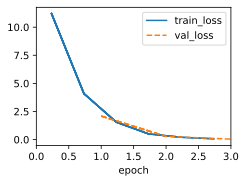

In [9]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)


データセットを自分たちで合成したため、実際のパラメータが何であるかを正確に知っています。したがって、トレーニング ループを通じて [**真のパラメーターと学習したパラメーターを比較することで、トレーニングの成功を評価する**] ことができます。実際、それらは互いに非常に近いことがわかります。


In [10]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1006, -0.1535], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2132], grad_fn=<RsubBackward1>)



グラウンドトゥルースパラメータを正確に復元できることを当然のことと考えるべきではありません。一般に、ディープ モデルの場合、パラメーターの一意の解は存在せず、線形モデルの場合でも、パラメーターを正確に回復できるのは、他の特徴に線形依存する特徴がない場合のみです。ただし、機械学習では、多くの場合、真の基礎となるパラメーターを回復することにはあまり関心がなく、高精度の予測につながるパラメーターに関心があります:cite: `Vapnik.1992` 。幸いなことに、確率的勾配降下法は、困難な最適化問題であっても、非常に優れた解決策を見つけることができます。これは、深層ネットワークでは、高精度の予測につながるパラメーターの構成が多数存在するという事実の一部によるものです。

## まとめ

このセクションでは、完全に機能するニューラル ネットワーク モデルとトレーニング ループを実装することにより、深層学習システムの設計に向けて重要な一歩を踏み出しました。このプロセスでは、データ ローダー、モデル、損失関数、最適化手順、および視覚化および監視ツールを構築しました。これを行うには、モデルのトレーニングに関連するすべてのコンポーネントを含む Python オブジェクトを作成します。これはまだプロレベルの実装ではありませんが、完全に機能しており、このようなコードはすでに小さな問題を迅速に解決するのに役立ちます。次のセクションでは、これを*より簡潔に*(定型コードを回避し) かつ*より効率的に*(GPU を最大限に活用して) 行う方法を見ていきます。

## 演習
1. 重みをゼロに初期化するとどうなるでしょうか。アルゴリズムはまだ機能するでしょうか?パラメータを $0.01$ ではなく $1,000$ の分散で初期化したらどうなるでしょうか?
1. あなたが[Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm)で、電圧と電流を関連付ける抵抗のモデルを考え出そうとしていると仮定します。自動微分を使用してモデルのパラメーターを学習できますか?
1. [プランクの法則](https://en.wikipedia.org/wiki/Planck%27s_law)を使用して、スペクトル エネルギー密度を使用して物体の温度を決定できますか?参考までに、黒体から発せられる放射線のスペクトル密度 $B$ は $B(\lambda, T) = \frac{2 hc^2}{\lambda^5} \cdot \left(\exp \frac{ hc}{\lambda k T} - 1\right)^{-1}$。ここで、$\lambda$ は波長、$T$ は温度、$c$ は光の速度、$h$ はプランク量子、$k$ はボルツマン定数です。さまざまな波長 $\lambda$ のエネルギーを測定し、スペクトル密度曲線をプランクの法則に当てはめる必要があります。
1. 損失の二次導関数を計算したい場合に遭遇する可能性のある問題は何ですか?どのように修正しますか?
1. なぜ`loss`関数に`reshape`メソッドが必要なのでしょうか?
1. さまざまな学習率を使用して実験し、損失関数値がどのくらいの速さで低下するかを調べます。トレーニングのエポック数を増やすことで誤差を減らすことができますか?
1. サンプルの数をバッチ サイズで割ることができない場合、エポックの終了時に`data_iter`はどうなりますか?
1. 絶対値損失`(y_hat - d2l.reshape(y, y_hat.shape)).abs().sum()`など、別の損失関数を実装してみてください。<ol><li>通常のデータで何が起こるかを確認してください。
1.  $y_5 = 10,000$ など、$\mathbf{y}$ の一部のエントリを積極的に摂動させた場合に動作に違いがあるかどうかを確認してください。
1. 二乗損失と絶対値損失の最良の側面を組み合わせた安価な解決策を考えられますか?ヒント: 非常に大きな勾配値を回避するにはどうすればよいでしょうか?



[ディスカッション](https://discuss.d2l.ai/t/43)
